In [1]:
using Distributions, PyPlot, LinearAlgebra, ForwardDiff

In [2]:
function set_options(ax, xlabel, ylabel, title; grid=true, gridy=false, legend=false)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if grid
        if gridy
            ax.grid(axis="y")
        else
            ax.grid()
        end
    end
    legend && ax.legend()
end

set_options (generic function with 1 method)

In [3]:
eye(n) = Diagonal{Float64}(I, n)

unzip(a) = map(x->getfield.(a, x), fieldnames(eltype(a)))

unzip (generic function with 1 method)

In [4]:
function HMC(log_p_tilde, μ₀; maxiter::Int=100_000, L::Int=100, ϵ::Float64=1e-1)
    function leapflog(grad, p_in, μ_in, L, ϵ)
        μ = μ_in
        p = p_in + 0.5*ϵ*grad(μ)
        for l in 1:L-1
            μ += ϵ*p
            p += ϵ*grad(μ)
        end
        μ += ϵ*p
        p += 0.5*ϵ*grad(μ)
        p, μ
    end
    
    grad(μ) = ForwardDiff.gradient(log_p_tilde, μ)
    
    D = length(μ₀)
    μ_samples = Array{typeof(μ₀[1]), 2}(undef, D, maxiter)
    
    μ_samples[:, 1] = μ₀
    
    num_accepted = 1
    
    for i in 2:maxiter
        p_in = randn(size(μ₀))
        
        p_out, μ_out = leapflog(grad, p_in, μ_samples[:, i-1], L, ϵ)
        
        μ_in = μ_samples[:, i-1]
        log_r = (log_p_tilde(μ_out) +
                        logpdf(MvNormal(zeros(D), eye(D)), vec(p_out))) - 
                        (log_p_tilde(μ_in) + 
                        logpdf(MvNormal(zeros(D), eye(D)), vec(p_in)))
        
        is_accepted = min(1, exp(log_r)) > rand()
        new_sample = is_accepted ? μ_out : μ_in
        
        μ_samples[:, i] = new_sample
        
        num_accepted += is_accepted
    end
    
    μ_samples, num_accepted
end

function inference_wrapper_HMC(log_joint, params, w_init; maxiter::Int=100000, L::Int=100, ϵ::Float64=1e-1)
    ulp(w) = log_joint(w, params...)
    HMC(ulp, w_init; maxiter=maxiter, L=L, ϵ=ϵ)
end

inference_wrapper_HMC (generic function with 1 method)

## ポアソン回帰

$p(Y, w|X) = p(w) \prod_{n=1}^N p(y_n|x_n, w) = \mathcal{N}(w|0, \sigma^2 I) \prod_{n=1}^N Poisson(y_n|\exp(w^Tx_n))$

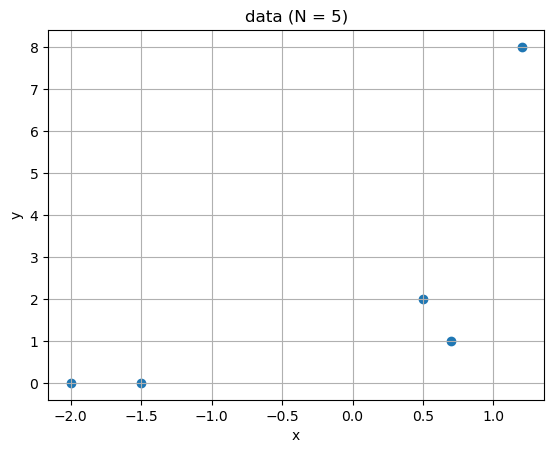

false

In [5]:
x_obs = [-2, -1.5, 0.5, 0.7, 1.2]

y_obs = [0.0, 0, 2, 1, 8]

fig, ax = subplots()
ax.scatter(x_obs, y_obs)
set_options(ax, "x", "y", "data (N = $(length(x_obs)))")

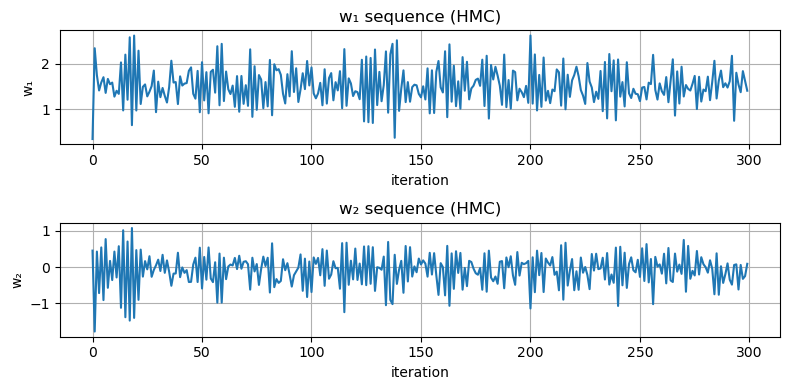

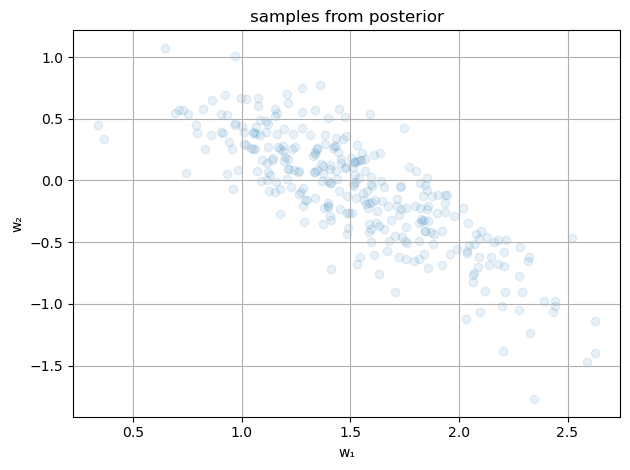

acceptance rate (HMC) = 1.0


In [6]:
log_joint(w, x, y) = 
    sum(logpdf.(Poisson.(exp.(w[1]*x .+ w[2])), y)) + 
    logpdf(Normal(0, 1.0), w[1]) + 
    logpdf(Normal(0, 1.0), w[2])

params = (x_obs, y_obs)
ulp(w) = log_joint(w, params...)
        
w_init = randn(2)

maxiter = 300
param_posterior, num_accepted = inference_wrapper_HMC(log_joint, params, w_init, maxiter=maxiter)

# HMC
fig, axes = subplots(2, 1, figsize=(8, 4))
axes[1].plot(param_posterior[1, :])
set_options(axes[1], "iteration", "w₁", "w₁ sequence (HMC)")
axes[2].plot(param_posterior[2, :])
set_options(axes[2], "iteration", "w₂", "w₂ sequence (HMC)")
tight_layout()
println("acceptance rate (HMC) = $(num_accepted / maxiter)")

fig, ax = subplots()
ax.scatter(param_posterior[1, :], param_posterior[2, :], alpha=0.1)
set_options(ax, "w₁", "w₂", "samples from posterior")
tight_layout()

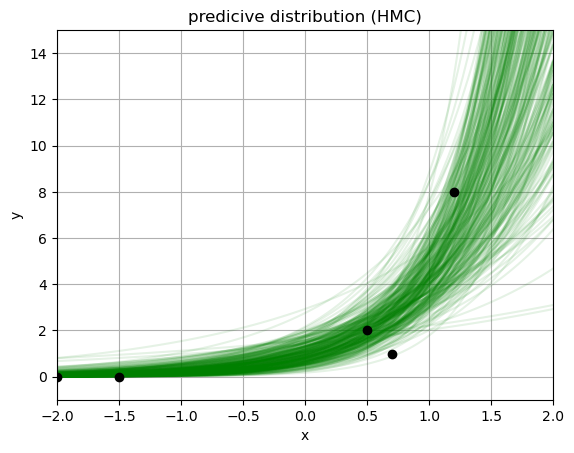

false

In [7]:
xs = range(-2, 2, length=100)

fig, ax = subplots()

# HMC
for i in 1:size(param_posterior, 2)
    w₁, w₂ = param_posterior[:, i]
    f(x) = exp.(w₁*x + w₂)
    ax.plot(xs, f.(xs), "g", alpha=0.1)
end
ax.plot(x_obs, y_obs, "ko")
ax.set_xlim(extrema(xs))
ax.set_ylim([-1, 15])
set_options(ax, "x", "y", "predicive distribution (HMC)")

## 階層ベイズモデル

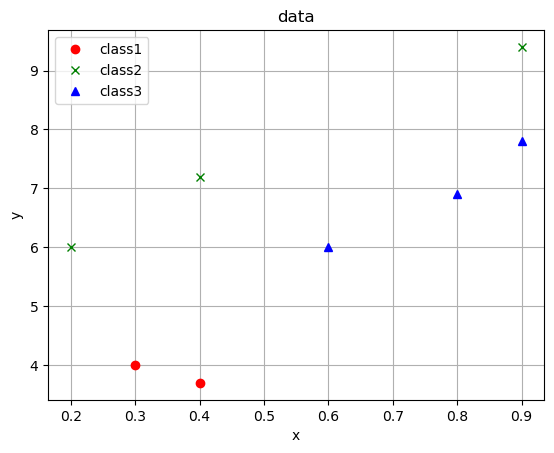

PyObject <matplotlib.legend.Legend object at 0x7f96ba7e5c10>

In [18]:
x_obs = []
y_obs = []

push!(x_obs, [0.3, 0.4])
push!(y_obs, [4.0, 3.7])


push!(x_obs, [0.2, 0.4, 0.9])
push!(y_obs, [6.0, 7.2, 9.4])

push!(x_obs, [0.6, 0.8, 0.9])
push!(y_obs, [6.0, 6.9, 7.8])

fig, ax = subplots()
ax.plot(x_obs[1], y_obs[1], "or", label="class1")
ax.plot(x_obs[2], y_obs[2], "xg", label="class2")
ax.plot(x_obs[3], y_obs[3], "^b", label="class3")
set_options(ax, "x", "y", "data", legend=true)

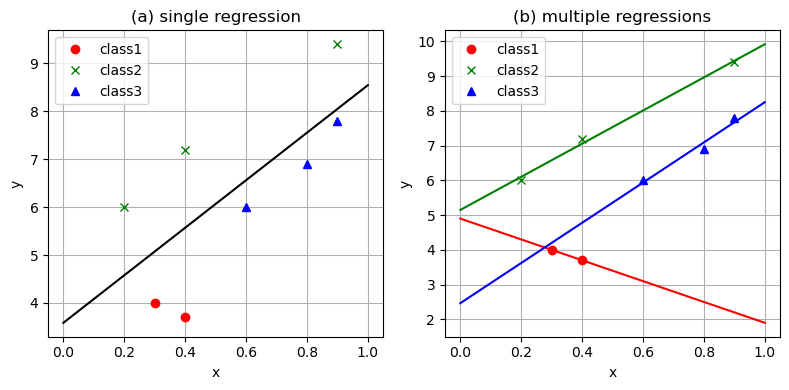

In [9]:
function linear_fit(y, x)
    N = length(x)
    w₁ = sum((y .- mean(y)) .* x) / sum((x .- mean(x)) .* x)
    w₂ = mean(y) - w₁*mean(x)
    w₁, w₂
end

w₁, w₂ = linear_fit(vcat(y_obs...), vcat(x_obs...))

w₁s = []
w₂s = []
for i in 1:3
    w₁_tmp, w₂_tmp = linear_fit(y_obs[i], x_obs[i])
    push!(w₁s, w₁_tmp)
    push!(w₂s, w₂_tmp)
end

xs = range(0, 1, length=100)

fig, axes = subplots(1, 2, figsize=(8, 4))

axes[1].plot(xs, w₁ .* xs .+ w₂, "-k")

axes[2].plot(xs, w₁s[1] .* xs .+ w₂s[1], "-r")
axes[2].plot(xs, w₁s[2] .* xs .+ w₂s[2], "-g")
axes[2].plot(xs, w₁s[3] .* xs .+ w₂s[3], "-b")

for ax in axes
    ax.plot(x_obs[1], y_obs[1], "or", label="class1")
    ax.plot(x_obs[2], y_obs[2], "xg", label="class2")
    ax.plot(x_obs[3], y_obs[3], "^b", label="class3")
end

set_options(axes[1], "x", "y", "(a) single regression", legend=true)
set_options(axes[2], "x", "y", "(b) multiple regressions", legend=true)

tight_layout()

階層ベイズに直す

$$p(Y, w|X) = p(w_1)p(w_2) \prod_{i=1}^3 \left\{p(w_1^{(i)}|w_1)p(w_2^{(2)}|w_2) \prod_{n=1}^{N_i} p(y_n^{(i)}|x_n^{(i)}, w_1^{(i)}, w_2^{(i)})\right\}$$

今回$w_1, w_2$はハイパーパラメータ
$$p(w_1) = \mathcal{N}(w_1|0, 10.0)$$
$$p(w_2) = \mathcal{N}(w_2|0, 10.0)$$

ハイパーパラメータが生成されると各クラスのパラメータが生成される
$$p(w_1^{(i)}|w_1) = \mathcal{N}(w_1^{(i)}|w_1, 1.0)$$
$$p(w_2^{(i)}|w_2) = \mathcal{N}(w_2^{(i)}|w_2, 1.0)$$

最後の部分は尤度
$$p(y_n^{(i)}|x_n^{(i)}, w_1^{(i)}, w_2^{(i)}) = \mathcal{N}(y_n^{(i)}|w_1^{(i)}x_n^{(i)} + w_2^{i}, 1.0)$$

In [19]:
@views hyper_prior(w) = logpdf(Normal(0, 10.0), w[1]) + logpdf(Normal(0, 10.0), w[2])
@views prior(w) = sum(logpdf.(Normal.(w[1], 1.0), w[3:5])) + sum(logpdf.(Normal.(w[2], 1.0), w[6:8]))
@views log_likelihood(y, x, w) = sum([sum(logpdf.(Normal.(y[i], 1.0), w[2+1].*x[i] .+ w[2+i+3])) for i in 1:3])

log_joint(w, x, y) = hyper_prior(w) + prior(w) + log_likelihood(y_obs, x_obs, w)
params = (y_obs, x_obs)
ulp(w) = hyper_prior(w) + prior(w) + log_likelihood(w, params...)

ulp (generic function with 1 method)

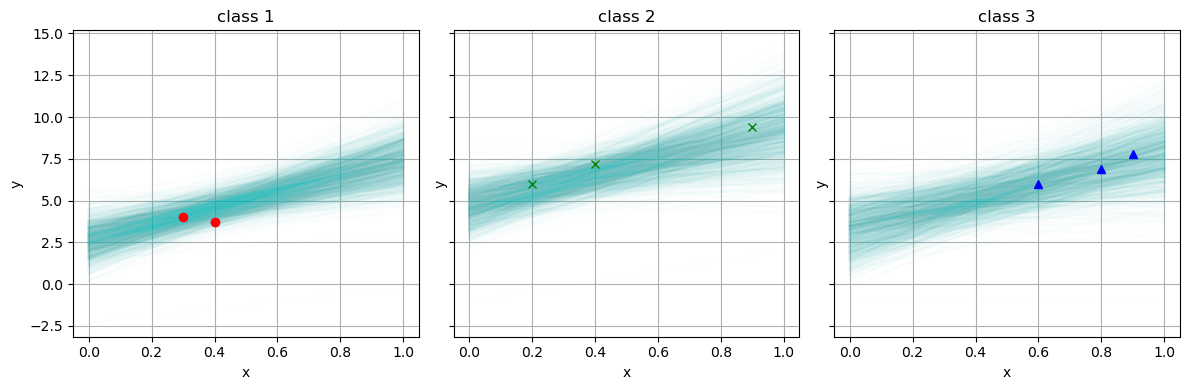

In [20]:
maxiter = 1000
w_init = randn(8)
param_posterior, num_accepted = inference_wrapper_HMC(log_joint, params, w_init, maxiter=maxiter, L=100, ϵ=0.01)

fig, axes = subplots(1, 3, sharey=true, figsize=(12, 4))

for i in 1:3
    for j in 1:size(param_posterior, 2)
        w₁, w₂ = param_posterior[[2+i, 2+i+3], j]
        axes[i].plot(xs, w₁ .* xs .+ w₂, "c-", alpha=0.01)
    end
    set_options(axes[i], "x", "y", "class $(i)")
end

axes[1].plot(x_obs[1], y_obs[1], "or", label="class1")
axes[2].plot(x_obs[2], y_obs[2], "xg", label="class2")
axes[3].plot(x_obs[3], y_obs[3], "^b", label="class3")

tight_layout()

In [21]:
x_obs = []
y_obs = []

push!(x_obs, [0.1, 0.3, 0.4, 0.5, 0.6, 0.9])
push!(y_obs, [4.0, 4.0, 3.7, 3.8, 3.9, 3.7])

push!(x_obs, [0.2, 0.4, 0.9])
push!(y_obs, [6.0, 7.2, 9.4])

push!(x_obs, [0.6, 0.8, 0.9])
push!(y_obs, [6.0, 6.9, 7.8])

3-element Vector{Any}:
 [4.0, 4.0, 3.7, 3.8, 3.9, 3.7]
 [6.0, 7.2, 9.4]
 [6.0, 6.9, 7.8]

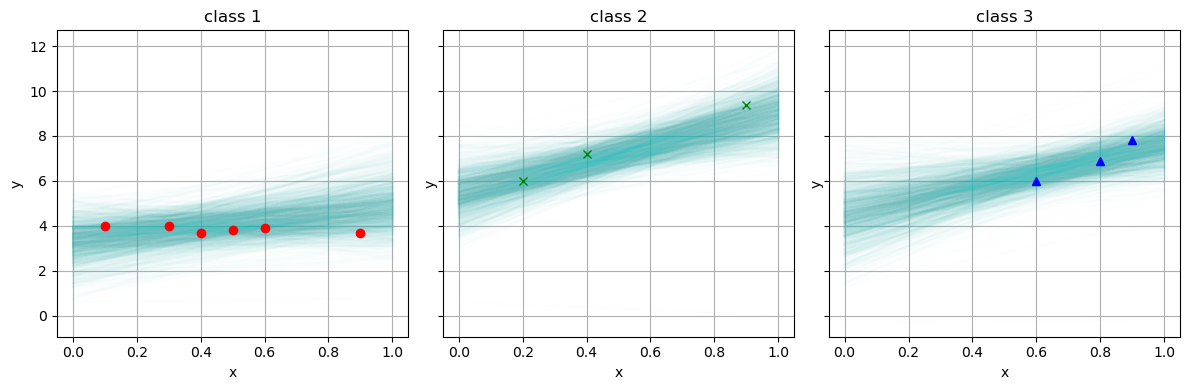

In [30]:
@views hyper_prior(w) = logpdf(Normal(0, 10.0), w[1]) + logpdf(Normal(0, 10.0), w[2])
@views prior(w) = sum(logpdf.(Normal.(w[1], 1.0), w[3:5])) + sum(logpdf.(Normal.(w[2], 1.0), w[6:8]))
@views log_likelihood(y, x, w) = sum([sum(logpdf.(Normal.(y[i], 1.0), w[2+i].*x[i] .+ w[2+i+3])) for i in 1:3])

log_joint(w, x, y) = hyper_prior(w) + prior(w) + log_likelihood(y_obs, x_obs, w)
params = (y_obs, x_obs)
ulp(w) = hyper_prior(w) + prior(w) + log_likelihood(w, params...)

maxiter = 1000
w_init = randn(8)
param_posterior, num_accepted = inference_wrapper_HMC(log_joint, params, w_init, maxiter=maxiter, L=100, ϵ=0.01)

fig, axes = subplots(1, 3, sharey=true, figsize=(12, 4))

for i in 1:3
    for j in 1:size(param_posterior, 2)
        w₁, w₂ = param_posterior[[2+i, 2+i+3], j]
        axes[i].plot(xs, w₁ .* xs .+ w₂, "c-", alpha=0.01)
    end
    set_options(axes[i], "x", "y", "class $(i)")
end

axes[1].plot(x_obs[1], y_obs[1], "or", label="class1")
axes[2].plot(x_obs[2], y_obs[2], "xg", label="class2")
axes[3].plot(x_obs[3], y_obs[3], "^b", label="class3")

tight_layout()

## 状態空間モデル

状態空間モデル$\rightarrow$各データの間に時間的依存性があると仮定される場合に有用  
状態変数$X = \{ x_1, x_2, ..., x_N \}$に対しマルコフ連鎖を考える

$$x_1 \sim \mathcal{N}(x_1|\mu, \Sigma_1)$$
$$x_n \sim \mathcal{N}(x_n|x_{n-1}, \Sigma_x) \quad for \quad n=2, 3, ..., N$$

### スムージング

データ系列$Y$から背後に存在すると仮定される状態変数$X$を抽出することを考える

$$p(X|Y) = \dfrac{p(Y|X)p(X)}{p(Y)} \propto \left\{ p(x_1)\prod_{n=2}^N p(x_n|x_{n-1})\right\}\left\{ \prod_{n=1}^N p(y_n|x_n)\right\}$$

観測ノイズの多い座標系列データ$Y$から、ノイズを除去した真の位置$X$を推定する問題に使えたりする(GPS等)

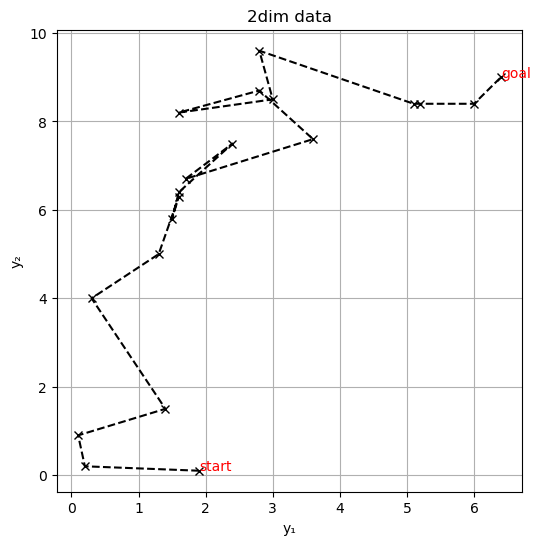

false

In [32]:
N = 20

D = 2

y_obs = 
    [1.9 0.2 0.1 1.4 0.3 1.3 1.6 1.5 1.6 2.4 #=
=# 1.7 3.6 2.8 1.6 3.0 2.8 5.1 5.2 6.0 6.4;
      0.1 0.2 0.9 1.5 4.0 5.0 6.3 5.8 6.4 7.5#=
=# 6.7 7.6 8.7 8.2 8.5 9.6 8.4 8.4 8.4 9.0]

fig, ax = subplots(figsize=(6, 6))
ax.plot(y_obs[1, :], y_obs[2, :], "kx--")
ax.text(y_obs[1, 1], y_obs[2, 1], "start", color="r")
ax.text(y_obs[1, end], y_obs[2, end], "goal", color="r")
set_options(ax, "y₁", "y₂", "2dim data")

In [35]:
# 初期状態に与えるノイズ
σ₁ = 100.0

# 状態遷移に仮定するノイズ
σ_x = 1.0

# 観測に仮定するノイズ
σ_y = 1.0

# 状態の遷移系列に関する対数密度
@views transition(x, σ₁, σ_x, D, N) = 
        logpdf(MvNormal(zeros(D), σ₁*eye(D)), x[:, 1]) + 
        sum([logpdf(MvNormal(x[:, n-1], σ_x*eye(D)), x[:, n]) for n in 2:N])
# 観測データに対する対数密度
@views observation(x, y, σ_y, D, N) = 
        sum([logpdf(MvNormal(x[:, n], σ_y*eye(D)), y[:, n]) for n in 1:N])

# 対数同時分布
log_joint_tmp(x, y, σ₁, σ_x, σ_y, D, N) = 
        transition(x, σ₁, σ_x, D, N) + 
        observation(x, y, σ_y, D, N)

log_joint(x_vec, y, σ₁, σ_x, σ_y, D, N) = 
        log_joint_tmp(reshape(x_vec, D, N), y, σ₁, σ_x, σ_y, D, N)
params = (y_obs, σ₁, σ_x, σ_y, D, N)

ulp(x_vec) = log_joint(x_vec, params...)

ulp (generic function with 1 method)

In [49]:
x_init = randn(D*N)

maxiter = 1000

samples, num_accepted = inference_wrapper_HMC(log_joint, params, x_init, maxiter=maxiter)

println("acceptance rate = $(num_accepted / maxiter)")

acceptance rate = 0.989


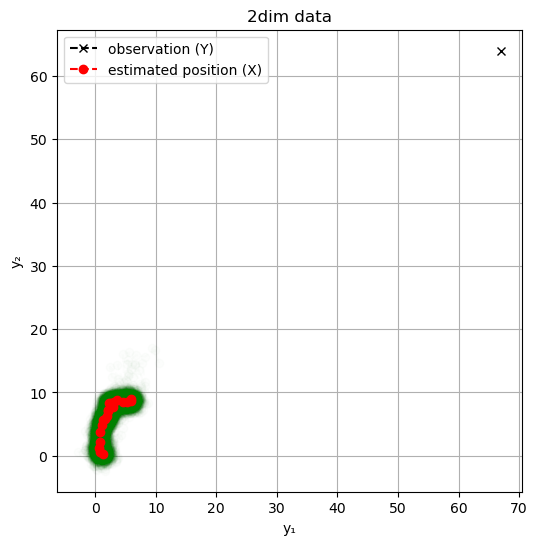

PyObject <matplotlib.legend.Legend object at 0x7f9687ece370>

In [50]:
fig, ax = subplots(figsize=(6, 6))
for i in 1:maxiter
    x = reshape(samples[:, i], D, N)
    ax.plot(x[1, :], x[2, :], "go--", alpha=10.0/maxiter)
end

ax.plot(y_obs[1, :], y_obs[2, :], "kx--", label="observation (Y)")

mean_trace = reshape(mean(samples, dims=2), D, N)
ax.plot(mean_trace[1, :], mean_trace[2, :], "ro--", label="estimated position (X)")

set_options(ax, "y₁", "y₂", "2dim data", legend=true)

### 回帰への適用

入力値$z$から出力値$y$を予測するモデルを考える、背後に直接観測できない経時的な変化成分$x$が存在すると仮定

$$p(Y, X, w|Z) = p(Y|X, Z, w)p(X)p(w) = p(w)\left \{p(x_1)\prod_{n=2}^N p(x_n|x_{n-1}) \right \} \left \{\prod_{n=1}^N p(y_n|x_{n}, z_n, w) \right \}$$

ただし
$$p(w) = \mathcal{N}(w_1|0, \sigma_w)\mathcal{N}(w_2|0, \sigma_w)$$
$$p(x_1) = \mathcal{N}(x_1|0, \sigma_1)$$
$$p(x_n|x_{n-1}) = \mathcal{N}(x_n|x_{n-1}, \sigma_x)$$
$$p(y_n|x_n, z_n, w) = \mathcal{N}(y_n|w_1x_n + w_2 + x_n, \sigma_y)$$

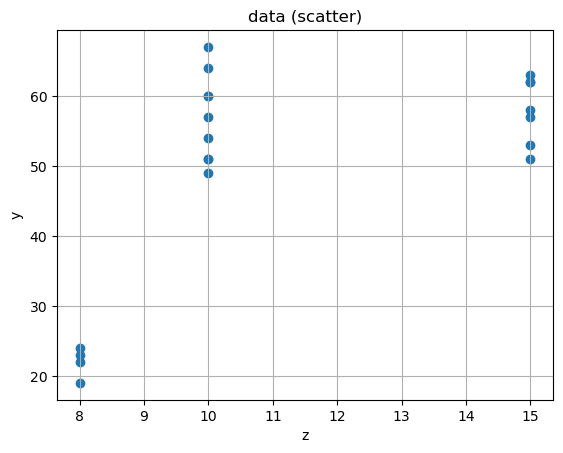

false

In [47]:
N = 20

z_obs = [10, 10, 10, 10, 10, 10, 10, 10, 10, 15,
                 15, 15, 15, 15, 15, 15, 8, 8, 8, 8]

y_obs = [67, 64, 60, 60, 57, 54, 51, 51, 49, 63, 
                 62, 62, 58, 57, 53, 51, 24, 22, 23, 19]

fig, ax = subplots()
ax.scatter(z_obs, y_obs)
set_options(ax, "z", "y", "data (scatter)")

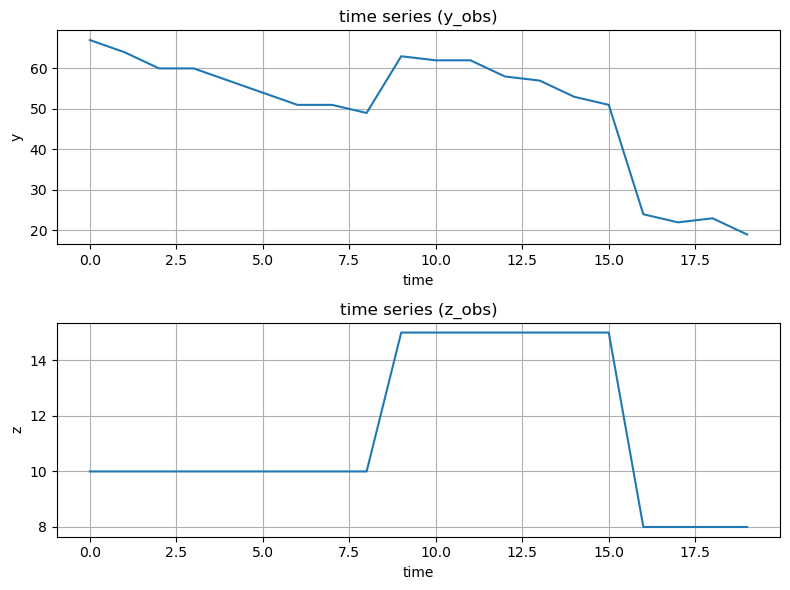

In [48]:
fig, axes = subplots(2, 1, figsize=(8, 6))

axes[1].plot(y_obs)
set_options(axes[1], "time", "y", "time series (y_obs)")

axes[2].plot(z_obs)
set_options(axes[2], "time", "z", "time series (z_obs)")

tight_layout()

In [59]:
# 初期状態に与えるノイズ
σ₀ = 10.0

# 状態遷移に仮定するノイズ
σ_x = 1.0

# 観測に仮定するノイズ
σ_y = 0.5

# パラメータに仮定するノイズ
σ_w = 100.0

# パラメータの事前分布
prior(w, σ_w) = logpdf(MvNormal(zeros(2), σ_w*eye(2)), w)

# 状態の遷移系列に関する対数密度
@views transition(x, σ₀, σ_x) = 
        logpdf(Normal(0, σ₀), x[1]) + 
        sum(logpdf.(Normal.(x[1:N-1], σ_x), x[2:N]))

# 観測データに対する対数密度
@views observation(x, y, z, w) = 
        sum(logpdf.(Normal.(w[1]*z .+ w[2] + x, σ_y), y))

# 対数同時分布
log_joint_tmp(x, w, y, z, σ_w, σ₀, σ_x) = 
        transition(x, σ₀, σ_x) + 
        observation(x, y, z, w) + prior(w, σ_w)

@views log_joint(x_vec, y, z, σ_w, σ₀, σ_x) = 
        transition(x_vec[1:N], σ₀, σ_x) + 
        observation(x_vec[1:N], y, z, x_vec[N+1:N+2]) + prior(x_vec[N+1:N+2], σ_w)
params = (y_obs, z_obs, σ_w, σ₀, σ_x)

x_init = randn(N+2)
maxiter = 1000
samples, num_accepted = inference_wrapper_HMC(log_joint, params, x_init, maxiter=maxiter, L=100, ϵ=1e-2)

println("acceptance rate = $(num_accepted / maxiter)")

acceptance rate = 0.952


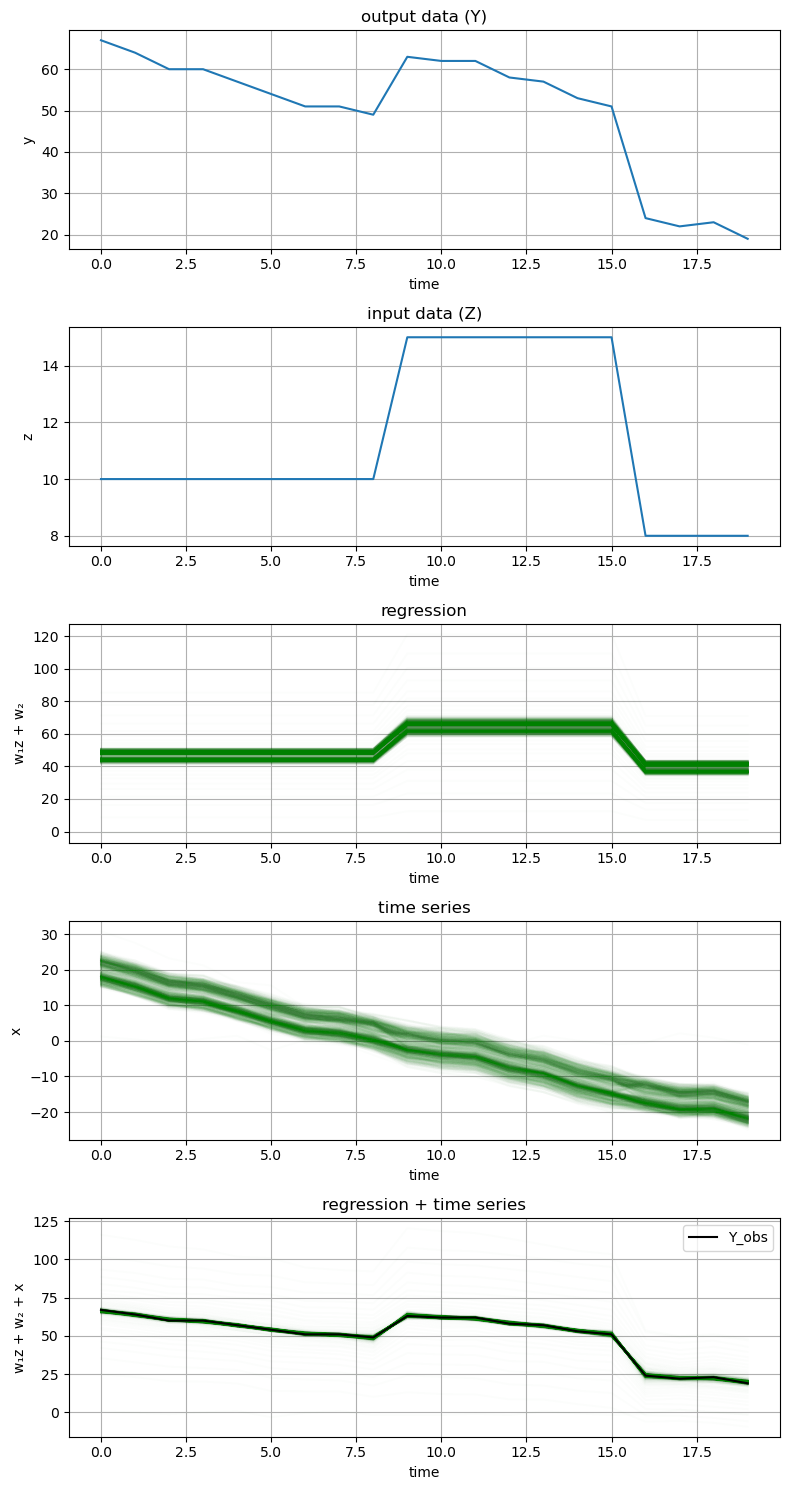

In [60]:
fig,axes = subplots(5, 1, figsize=(8, 15))

axes[1].plot(y_obs)
set_options(axes[1], "time", "y", "output data (Y)")

axes[2].plot(z_obs)
set_options(axes[2], "time", "z", "input data (Z)")

for i in 1:maxiter
    w₁, w₂ = samples[[N+1, N+2], i]
    axes[3].plot(w₁*z_obs .+ w₂, "g-", alpha=10/maxiter)
end
set_options(axes[3], "time", "w₁z + w₂", "regression")

for i in 1:maxiter
    x = samples[1:N, i]
    axes[4].plot(x, "g-", alpha=10/maxiter)
end
set_options(axes[4], "time", "x", "time series")

for i in 1:maxiter
    w₁, w₂ = samples[[N+1, N+2], i]
    x = samples[1:N, i]
    axes[5].plot(w₁*z_obs .+ w₂ + x, "g-", alpha=10/maxiter)
end
axes[5].plot(y_obs, "k", label="Y_obs")
set_options(axes[5], "time", "w₁z + w₂ + x", "regression + time series", legend=true)

tight_layout()